# Analysis of Washington Post headlines during the COVID-19 pandemic

The Washington Post is the #7 newspaper in the U.S. by circulation. https://en.wikipedia.org/wiki/List_of_newspapers_in_the_United_States#Top_10_newspapers_by_circulation

Digital circulation is more difficult to gauge. The Washington Post is one of the newspapers that have not fully reported their digital circulation to the Alliance for Audited Media (AAM), the group that audits the circulation figures of many of the largest North American newspapers and other publications. https://www.journalism.org/fact-sheet/newspapers/

Nevertheless the Washington Post is a top newspaper in the United States. 

This notebook analyzes how the headlines have evolved since the day the first case appeared in the U.S.

Import libraries.

In [675]:
from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.common.exceptions import StaleElementReferenceException
from selenium.webdriver.support import expected_conditions as EC
import datetime
import pandas as pd
import time
from ast import literal_eval
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scipy
import gensim
from sklearn.manifold import TSNE
from datetime import timedelta
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from timeit import default_timer as timer
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
%matplotlib notebook

Set date range we are interested in.

In [242]:
start_day = datetime.date(2020, 1, 21)
end_day = datetime.date.today()
days = (end_day - start_day).days 
desired_range = pd.date_range(start_day, periods=days).tolist()
print('Range: ' + str(start_day) + ' to ' + str(end_day))
print('Days: ' + str(days))
desired_range

Range: 2020-01-21 to 2020-04-09
Days: 79


[Timestamp('2020-01-21 00:00:00', freq='D'),
 Timestamp('2020-01-22 00:00:00', freq='D'),
 Timestamp('2020-01-23 00:00:00', freq='D'),
 Timestamp('2020-01-24 00:00:00', freq='D'),
 Timestamp('2020-01-25 00:00:00', freq='D'),
 Timestamp('2020-01-26 00:00:00', freq='D'),
 Timestamp('2020-01-27 00:00:00', freq='D'),
 Timestamp('2020-01-28 00:00:00', freq='D'),
 Timestamp('2020-01-29 00:00:00', freq='D'),
 Timestamp('2020-01-30 00:00:00', freq='D'),
 Timestamp('2020-01-31 00:00:00', freq='D'),
 Timestamp('2020-02-01 00:00:00', freq='D'),
 Timestamp('2020-02-02 00:00:00', freq='D'),
 Timestamp('2020-02-03 00:00:00', freq='D'),
 Timestamp('2020-02-04 00:00:00', freq='D'),
 Timestamp('2020-02-05 00:00:00', freq='D'),
 Timestamp('2020-02-06 00:00:00', freq='D'),
 Timestamp('2020-02-07 00:00:00', freq='D'),
 Timestamp('2020-02-08 00:00:00', freq='D'),
 Timestamp('2020-02-09 00:00:00', freq='D'),
 Timestamp('2020-02-10 00:00:00', freq='D'),
 Timestamp('2020-02-11 00:00:00', freq='D'),
 Timestamp

Open the calendar for Washington Post in the Internet archives.

In [256]:
url = 'https://web.archive.org/web/*/washingtonpost.com'
browser = webdriver.Firefox(executable_path='/usr/local/bin/geckodriver') # brew install chromedriver then see in terminal where it was installed to and paste this
browser.get(url)
WebDriverWait(browser, 20).until(EC.element_to_be_clickable((By.CLASS_NAME, 'calendar-grid')))

<selenium.webdriver.firefox.webelement.FirefoxWebElement (session="20be8f11-6315-7c47-a760-46c1d5f8343d", element="e2521cf8-956f-5f4c-9d05-1d1c0ebb45ef")>

In [257]:
dates = browser.find_elements_by_css_selector('.calendar-day')
data = {}

For each day since the beginning of our range, collect headlines from the last front page snapshot of that day.

In [258]:
for i in range(0, len(dates)):
    # Hover over the date, let popup appear, wait for loader to disappear, select scroll area
    hov = ActionChains(browser).move_to_element(dates[i])
    hov.perform()
    popup = WebDriverWait(browser, 20).until(EC.visibility_of_element_located((By.CSS_SELECTOR, '.popup-of-day-content')))
    WebDriverWait(browser, 20).until(EC.invisibility_of_element_located((By.TAG_NAME, 'svg')))
    scroll_area = WebDriverWait(browser, 20).until(EC.visibility_of_element_located((By.CSS_SELECTOR, '.popup-of-day-content > ul > div')))
    
    # Get date and check that it is in our range
    date = popup.find_element_by_class_name('day-tooltip-title')
    date_formatted = datetime.datetime.strptime(date.text, '%B %d, %Y')
    print('Date: ' + str(date_formatted))
    if date_formatted not in desired_range:
        continue # skip if it is not
    else:
        attempts = 0
        while attempts < 2:
            try:
                browser.execute_script('arguments[0].scrollTop = arguments[0].scrollHeight', scroll_area)
                snapshots = popup.find_elements_by_tag_name('a')        
                last_snapshot = snapshots[len(snapshots) - 1]

                print('Last snapshot taken at ' + last_snapshot.text)
                data[date_formatted] = {'link': last_snapshot.get_attribute('href'),
                                             'time': last_snapshot.text,
                                             'headlines': []}
                break
            except StaleElementReferenceException:
                attempts += 1

Date: 2020-01-01 00:00:00
Date: 2020-01-02 00:00:00
Date: 2020-01-03 00:00:00
Date: 2020-01-04 00:00:00
Date: 2020-01-05 00:00:00
Date: 2020-01-06 00:00:00
Date: 2020-01-07 00:00:00
Date: 2020-01-08 00:00:00
Date: 2020-01-09 00:00:00
Date: 2020-01-10 00:00:00
Date: 2020-01-11 00:00:00
Date: 2020-01-12 00:00:00
Date: 2020-01-13 00:00:00
Date: 2020-01-14 00:00:00
Date: 2020-01-15 00:00:00
Date: 2020-01-16 00:00:00
Date: 2020-01-17 00:00:00
Date: 2020-01-18 00:00:00
Date: 2020-01-19 00:00:00
Date: 2020-01-20 00:00:00
Date: 2020-01-21 00:00:00
Last snapshot taken at 22:49:50
Date: 2020-01-22 00:00:00
Last snapshot taken at 23:44:50
Date: 2020-01-23 00:00:00
Last snapshot taken at 23:28:13
Date: 2020-01-24 00:00:00
Last snapshot taken at 23:50:25
Date: 2020-01-25 00:00:00
Last snapshot taken at 23:58:33
Date: 2020-01-26 00:00:00
Last snapshot taken at 23:55:10
Date: 2020-01-27 00:00:00
Last snapshot taken at 23:57:41
Date: 2020-01-28 00:00:00
Last snapshot taken at 22:43:53
Date: 2020-01-29

In [259]:
data

{datetime.datetime(2020, 1, 21, 0, 0): {'link': 'https://web.archive.org/web/20200121224950/washingtonpost.com',
  'time': '22:49:50',
  'headlines': []},
 datetime.datetime(2020, 1, 22, 0, 0): {'link': 'https://web.archive.org/web/20200122234450/washingtonpost.com',
  'time': '23:44:50',
  'headlines': []},
 datetime.datetime(2020, 1, 23, 0, 0): {'link': 'https://web.archive.org/web/20200123232813/washingtonpost.com',
  'time': '23:28:13',
  'headlines': []},
 datetime.datetime(2020, 1, 24, 0, 0): {'link': 'https://web.archive.org/web/20200124235025/washingtonpost.com',
  'time': '23:50:25',
  'headlines': []},
 datetime.datetime(2020, 1, 25, 0, 0): {'link': 'https://web.archive.org/web/20200125235833/washingtonpost.com',
  'time': '23:58:33',
  'headlines': []},
 datetime.datetime(2020, 1, 26, 0, 0): {'link': 'https://web.archive.org/web/20200126235510/washingtonpost.com',
  'time': '23:55:10',
  'headlines': []},
 datetime.datetime(2020, 1, 27, 0, 0): {'link': 'https://web.archive.o

Scrape headlines from each page in the links.

In [267]:
for day in data:
    if len(data[day]['headlines']) == 0:
        print('Scraping ' + str(day) + '...')
        link = data[day]['link']
        browser.get(link)
        data[day]['headlines'] = [x.text for x in browser.find_elements_by_class_name('headline')]
        time.sleep(5) 

Scraping 2020-03-16 00:00:00...
Scraping 2020-03-17 00:00:00...
Scraping 2020-03-18 00:00:00...
Scraping 2020-03-19 00:00:00...
Scraping 2020-03-20 00:00:00...
Scraping 2020-03-21 00:00:00...
Scraping 2020-03-22 00:00:00...
Scraping 2020-03-23 00:00:00...
Scraping 2020-03-24 00:00:00...
Scraping 2020-03-25 00:00:00...
Scraping 2020-03-26 00:00:00...
Scraping 2020-03-27 00:00:00...
Scraping 2020-03-28 00:00:00...
Scraping 2020-03-29 00:00:00...
Scraping 2020-03-30 00:00:00...
Scraping 2020-03-31 00:00:00...
Scraping 2020-04-06 00:00:00...
Scraping 2020-04-04 00:00:00...
Scraping 2020-04-05 00:00:00...
Scraping 2020-04-07 00:00:00...
Scraping 2020-04-08 00:00:00...


In [261]:
data[datetime.datetime(2020, 1, 21, 0, 0)]['headlines']

['House managers, Trump’s legal team spar over rules to guide trial',
 'Senate rejects Democratic effort to subpoena White House for Ukraine documents',
 'How McConnell’s proposed trial will work',
 'How much power does Chief Justice Roberts have in the impeachment trial?',
 'Analysis: Trump’s legal team begins its impeachment trial defense in very Trumpy form',
 'Mike Bloomberg shifts presidential ad campaign to focus on impeachment',
 'He’s a vulnerable Republican in a trending-blue state. So why won’t he defy Trump on impeachment?',
 'Analysis: Senate Majority Leader Mitch McConnell has a new nickname: #MidnightMitch',
 'First U.S. case of potentially deadly coronavirus confirmed in Washington state',
 'More U.S. troops leave Iraq for medical treatment after Iranian missile attack, Pentagon says',
 'Hillary Clinton savages Bernie Sanders: ‘Nobody likes him’',
 'Impeachment is a race to the bottom. And no one really wins.',
 'Democrats already have these four victories in the impeach

In [268]:
data

{datetime.datetime(2020, 1, 21, 0, 0): {'link': 'https://web.archive.org/web/20200121224950/washingtonpost.com',
  'time': '22:49:50',
  'headlines': ['House managers, Trump’s legal team spar over rules to guide trial',
   'Senate rejects Democratic effort to subpoena White House for Ukraine documents',
   'How McConnell’s proposed trial will work',
   'How much power does Chief Justice Roberts have in the impeachment trial?',
   'Analysis: Trump’s legal team begins its impeachment trial defense in very Trumpy form',
   'Mike Bloomberg shifts presidential ad campaign to focus on impeachment',
   'He’s a vulnerable Republican in a trending-blue state. So why won’t he defy Trump on impeachment?',
   'Analysis: Senate Majority Leader Mitch McConnell has a new nickname: #MidnightMitch',
   'First U.S. case of potentially deadly coronavirus confirmed in Washington state',
   'More U.S. troops leave Iraq for medical treatment after Iranian missile attack, Pentagon says',
   'Hillary Clinton 

In [263]:
desired_range.index(datetime.datetime(2020, 2, 17, 0, 0))

27

In [296]:
df = pd.DataFrame.from_dict(data).T.rename_axis('date').reset_index()
df

,date,link,time,headlines
0,2020-01-21,https://web.archive.org/web/20200121224950/was...,22:49:50,"[House managers, Trump’s legal team spar over ..."
1,2020-01-22,https://web.archive.org/web/20200122234450/was...,23:44:50,[Senate hears opening arguments making the cas...
2,2020-01-23,https://web.archive.org/web/20200123232813/was...,23:28:13,[House managers focus on Trump’s alleged abuse...
3,2020-01-24,https://web.archive.org/web/20200124235025/was...,23:50:25,"[House managers turn to obstruction charge, In..."
4,2020-01-25,https://web.archive.org/web/20200125235833/was...,23:58:33,[Trump’s team argues president did nothing wro...
...,...,...,...,...
67,2020-04-06,https://web.archive.org/web/20200406235103/was...,23:51:03,"[Trump, congressional leaders converge on need..."
68,2020-04-04,https://web.archive.org/web/20200404231743/was...,23:17:43,"[Denial, dysfunction, delays: Tracing Trump ad..."
69,2020-04-05,https://web.archive.org/web/20200405234546/was...,23:45:46,[Virus death toll in U.S. almost certainly hig...
70,2020-04-07,https://web.archive.org/web/20200407223927/was...,22:39:27,[Trump removes inspector general who was to ov...


In [297]:
df.to_csv('headlines.csv', index=False)

In [678]:
df = pd.read_csv('headlines.csv', index_col=False, parse_dates=['date'])
df

,date,link,time,headlines
0,2020-01-21,https://web.archive.org/web/20200121224950/was...,22:49:50,"['House managers, Trump’s legal team spar over..."
1,2020-01-22,https://web.archive.org/web/20200122234450/was...,23:44:50,['Senate hears opening arguments making the ca...
2,2020-01-23,https://web.archive.org/web/20200123232813/was...,23:28:13,['House managers focus on Trump’s alleged abus...
3,2020-01-24,https://web.archive.org/web/20200124235025/was...,23:50:25,"['House managers turn to obstruction charge', ..."
4,2020-01-25,https://web.archive.org/web/20200125235833/was...,23:58:33,['Trump’s team argues president did nothing wr...
...,...,...,...,...
67,2020-04-06,https://web.archive.org/web/20200406235103/was...,23:51:03,"['Trump, congressional leaders converge on nee..."
68,2020-04-04,https://web.archive.org/web/20200404231743/was...,23:17:43,"['Denial, dysfunction, delays: Tracing Trump a..."
69,2020-04-05,https://web.archive.org/web/20200405234546/was...,23:45:46,['Virus death toll in U.S. almost certainly hi...
70,2020-04-07,https://web.archive.org/web/20200407223927/was...,22:39:27,['Trump removes inspector general who was to o...


In [326]:
df['headlines'] = df['headlines'].apply(literal_eval)
all_headlines = np.concatenate(df['headlines'].values)

In [345]:
all_headlines

array(['House managers, Trump’s legal team spar over rules to guide trial',
       'Senate rejects Democratic effort to subpoena White House for Ukraine documents',
       'How McConnell’s proposed trial will work', ...,
       'Building the future of food justice', 'The risks from within',
       "One size doesn't fit all"], dtype='<U204')

In [346]:
len(list(all_headlines))

4075

## Analysis

**Word length of headlines.**

In [367]:
headline_lengths = [len(x.split(' ')) for x in all_headlines]
headline_lengths

[11,
 11,
 6,
 12,
 13,
 10,
 16,
 11,
 11,
 14,
 8,
 12,
 10,
 6,
 10,
 14,
 12,
 12,
 15,
 16,
 14,
 17,
 15,
 12,
 11,
 14,
 3,
 1,
 20,
 9,
 17,
 9,
 10,
 12,
 11,
 11,
 9,
 16,
 13,
 12,
 15,
 11,
 14,
 16,
 18,
 16,
 16,
 7,
 5,
 6,
 9,
 11,
 15,
 16,
 14,
 13,
 12,
 14,
 12,
 13,
 13,
 7,
 13,
 5,
 8,
 5,
 12,
 14,
 14,
 15,
 17,
 10,
 14,
 12,
 9,
 16,
 3,
 1,
 18,
 7,
 17,
 9,
 10,
 12,
 13,
 13,
 11,
 9,
 9,
 13,
 12,
 11,
 14,
 9,
 18,
 16,
 16,
 7,
 5,
 6,
 9,
 13,
 16,
 11,
 13,
 9,
 15,
 10,
 7,
 6,
 8,
 6,
 14,
 7,
 10,
 15,
 17,
 14,
 10,
 15,
 11,
 9,
 16,
 13,
 12,
 3,
 1,
 18,
 7,
 17,
 9,
 7,
 12,
 10,
 10,
 13,
 10,
 9,
 22,
 15,
 12,
 16,
 12,
 8,
 8,
 19,
 17,
 16,
 5,
 3,
 4,
 6,
 10,
 12,
 17,
 18,
 14,
 13,
 18,
 14,
 7,
 8,
 12,
 20,
 12,
 7,
 12,
 10,
 12,
 13,
 7,
 18,
 15,
 15,
 9,
 6,
 10,
 14,
 6,
 16,
 6,
 3,
 1,
 8,
 7,
 17,
 9,
 7,
 12,
 10,
 10,
 14,
 10,
 9,
 20,
 13,
 8,
 12,
 12,
 8,
 8,
 19,
 17,
 10,
 5,
 3,
 4,
 11,
 13,
 5,
 6,
 15,
 14,
 12,


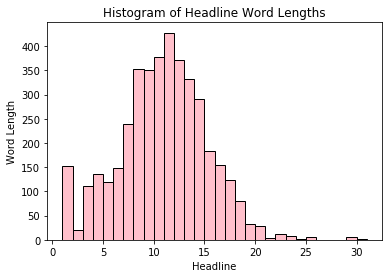

In [373]:
plt.hist(headline_lengths, color='pink', edgecolor='black', bins=30)
plt.title('Histogram of Headline Word Lengths')
plt.xlabel('Headline')
plt.ylabel('Word Length')
plt.show()

Most papers are 11 words in length. 

In [381]:
scipy.mode(headline_lengths).mode[0]

11

**Load pre-trained word2vec model**

Since this is a news dataset, we use the Google News model, which was trained on about 100 billion words. Download it here. https://code.google.com/archive/p/word2vec/

Other models: https://github.com/RaRe-Technologies/gensim-data

In [385]:
model = gensim.models.KeyedVectors.load_word2vec_format(
    'GoogleNews-vectors-negative300.bin', binary=True)

Check dimension of word vectors

In [386]:
model.vector_size

300

word2vec can't create a vector from a word that's not in its vocabulary. Because of this, we need to specify "if word in model.vocab" when creating the full list of word vectors.

In [452]:
stop_words = set(stopwords.words('english'))

In [437]:
words = ' '.join(all_headlines).split(' ')
words

['House',
 'managers,',
 'Trump’s',
 'legal',
 'team',
 'spar',
 'over',
 'rules',
 'to',
 'guide',
 'trial',
 'Senate',
 'rejects',
 'Democratic',
 'effort',
 'to',
 'subpoena',
 'White',
 'House',
 'for',
 'Ukraine',
 'documents',
 'How',
 'McConnell’s',
 'proposed',
 'trial',
 'will',
 'work',
 'How',
 'much',
 'power',
 'does',
 'Chief',
 'Justice',
 'Roberts',
 'have',
 'in',
 'the',
 'impeachment',
 'trial?',
 'Analysis:',
 'Trump’s',
 'legal',
 'team',
 'begins',
 'its',
 'impeachment',
 'trial',
 'defense',
 'in',
 'very',
 'Trumpy',
 'form',
 'Mike',
 'Bloomberg',
 'shifts',
 'presidential',
 'ad',
 'campaign',
 'to',
 'focus',
 'on',
 'impeachment',
 'He’s',
 'a',
 'vulnerable',
 'Republican',
 'in',
 'a',
 'trending-blue',
 'state.',
 'So',
 'why',
 'won’t',
 'he',
 'defy',
 'Trump',
 'on',
 'impeachment?',
 'Analysis:',
 'Senate',
 'Majority',
 'Leader',
 'Mitch',
 'McConnell',
 'has',
 'a',
 'new',
 'nickname:',
 '#MidnightMitch',
 'First',
 'U.S.',
 'case',
 'of',
 'poten

In [391]:
model['coronavirus']

array([-0.45507812,  0.06787109,  0.08496094,  0.12402344, -0.27929688,
       -0.20800781, -0.0133667 , -0.01672363,  0.38867188,  0.33984375,
        0.6640625 , -0.46679688,  0.26757812, -0.01373291, -0.68359375,
        0.4609375 , -0.20703125,  0.44140625,  0.09521484, -0.24707031,
        0.20800781, -0.36523438,  0.04272461, -0.15039062, -0.02624512,
        0.05053711, -0.10986328, -0.41796875,  0.40039062,  0.06079102,
       -0.51953125, -0.58984375,  0.734375  , -0.12890625,  0.01544189,
        0.13476562, -0.328125  ,  0.17089844,  0.42773438,  0.52734375,
       -0.01953125, -0.3828125 , -0.58984375,  0.63671875,  0.05151367,
       -0.37109375,  0.21484375,  0.1875    , -0.22949219,  0.31054688,
       -0.04882812, -0.21679688, -0.11523438, -0.13769531, -0.234375  ,
        0.44140625, -0.22460938,  0.21875   ,  0.10107422,  0.23535156,
        0.15136719,  0.49609375, -0.14355469,  0.12011719,  0.11474609,
       -0.37109375,  0.1953125 , -0.32226562, -0.20996094,  0.77

In [439]:
vector_list = [model[word] for word in words if word in model.vocab]
len(vector_list)

33252

Create a list of the words corresponding to these vectors

In [440]:
words_filtered = [word for word in words if word in model.vocab]
len(words_filtered)

33252

Zip the words together with their vector representations

In [441]:
word_vec_zip = zip(words_filtered, vector_list)
word_vec_zip

Cast to dict so we can turn it into a DataFrame

In [442]:
word_vec_dict = dict(word_vec_zip)
df_words = pd.DataFrame.from_dict(word_vec_dict, orient='index')
df_words.head(10)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
House,0.065430,0.058838,-0.328125,0.035156,-0.214844,-0.079102,0.141602,0.300781,0.096191,0.088867,...,-0.300781,-0.148438,-0.063477,0.065918,-0.180664,-0.077637,-0.140625,-0.130859,0.187500,0.241211
legal,-0.237305,0.124023,-0.184570,-0.027710,0.063965,0.118164,0.178711,0.173828,0.146484,0.102539,...,0.216797,-0.034912,-0.073242,-0.054443,-0.062988,0.277344,0.111816,-0.061279,-0.054199,0.205078
team,-0.253906,0.028564,0.104492,-0.075684,0.104980,-0.024170,-0.107910,-0.216797,0.093262,0.030640,...,-0.036865,0.138672,-0.163086,-0.168945,-0.031128,0.137695,0.013000,-0.081543,-0.092773,-0.068848
spar,-0.172852,0.388672,-0.098145,-0.100586,-0.148438,0.210938,0.012756,0.037109,0.092285,0.375000,...,0.339844,-0.417969,0.129883,0.255859,-0.494141,-0.343750,-0.226562,-0.110352,-0.271484,0.125977
over,0.088867,0.095703,0.014771,0.060791,-0.037598,-0.207031,0.004913,-0.324219,0.145508,0.275391,...,-0.020508,0.109375,-0.086426,0.028931,-0.137695,-0.064941,-0.053955,-0.006378,-0.193359,-0.100586
rules,-0.069824,0.133789,0.238281,0.021362,-0.194336,-0.259766,-0.074219,0.032959,-0.241211,-0.115234,...,-0.034912,-0.041992,0.082031,-0.310547,0.073242,-0.038086,0.219727,-0.127930,-0.031738,-0.055176
guide,0.038330,-0.022949,-0.138672,-0.263672,0.002792,-0.018677,-0.088867,-0.072754,-0.027466,-0.335938,...,0.022827,-0.072266,0.096191,-0.119629,-0.014343,-0.053223,-0.084473,-0.050049,0.171875,0.153320
trial,-0.091797,0.186523,-0.031738,0.154297,0.213867,0.016602,0.226562,-0.072266,0.120605,0.328125,...,0.086914,-0.053223,0.021973,-0.068359,0.087402,0.095215,-0.089355,-0.175781,0.018433,0.211914
Senate,0.006744,-0.021240,-0.277344,0.133789,-0.265625,-0.347656,0.025391,0.410156,0.184570,0.101074,...,-0.404297,-0.229492,0.106445,-0.195312,-0.079590,0.122559,-0.225586,-0.133789,0.267578,0.378906
rejects,0.009827,0.226562,0.281250,-0.361328,-0.060791,0.058838,0.102051,-0.035400,0.147461,0.128906,...,-0.075195,-0.185547,-0.283203,0.318359,-0.361328,0.251953,0.078613,0.030640,-0.103516,0.203125


Find titles that cluster together.

Instead of using doc2vec, which does not have pre-trained models available and so would require a lengthy training proocess, we can use a simpler (and sometimes even more effective) trick: averaging the embeddings of the word vectors in each document. In our case, a document refers to a title. https://towardsdatascience.com/using-word2vec-to-analyze-news-headlines-and-predict-article-success-cdeda5f14751

In [444]:
def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in model.vocab]
    return np.mean(model[doc], axis=0)

# Our earlier preprocessing was done when we were dealing only with word vectors
# Here, we need each document to remain a document 
def preprocess(text):
    text = text.lower()
    doc = word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    doc = [word for word in doc if word.isalpha()] 
    return doc

# Function that will help us drop documents that have no word vectors in word2vec
def has_vector_representation(word2vec_model, doc):
    """check if at least one word of the document is in the
    word2vec dictionary"""
    return not all(word not in word2vec_model.vocab for word in doc)

# Filter out documents
def filter_docs(corpus, texts, condition_on_doc):
    """
    Filter corpus and texts given the function condition_on_doc which takes a doc. The document doc is kept if condition_on_doc(doc) is true.
    """
    number_of_docs = len(corpus)

    if texts is not None:
        texts = [text for (text, doc) in zip(texts, corpus)
                 if condition_on_doc(doc)]

    corpus = [doc for doc in corpus if condition_on_doc(doc)]

    print("{} docs removed".format(number_of_docs - len(corpus)))

    return (corpus, texts)

Preprocess the corpus.

In [453]:
corpus = [preprocess(title) for title in all_headlines]

Remove docs that don't include any words in W2V's vocab

In [455]:
corpus, titles_list = filter_docs(corpus, 
                                  all_headlines, 
                                  lambda doc: has_vector_representation(model, doc))

153 docs removed


Filter out any empty docs

In [456]:
corpus, titles_list = filter_docs(corpus, 
                                  all_headlines, 
                                  lambda doc: (len(doc) != 0))

0 docs removed


In [457]:
x = []
for doc in corpus: # append the vector for each document
    x.append(document_vector(model, doc))
    
X = np.array(x) # list to array

In [458]:
X

array([[-0.09486219,  0.10024685, -0.01056586, ..., -0.11677381,
        -0.03533936,  0.08824328],
       [-0.01110162,  0.0616862 ,  0.03975995, ..., -0.06128608,
        -0.02565002,  0.06477865],
       [-0.06600952,  0.05895996,  0.06152344, ..., -0.0677948 ,
         0.02059937,  0.0579834 ],
       ...,
       [-0.08825684,  0.09500122,  0.03942871, ..., -0.05781555,
         0.12561035,  0.01688385],
       [-0.0949707 , -0.04296875,  0.08349609, ..., -0.0300293 ,
         0.03051758, -0.14111328],
       [-0.04170736,  0.11686198,  0.02229818, ...,  0.03027344,
         0.00777181, -0.08314768]], dtype=float32)

In [571]:
model.most_similar(positive=['coronavirus'])

[('corona_virus', 0.7276226878166199),
 ('coronaviruses', 0.7216537594795227),
 ('paramyxovirus', 0.7113004326820374),
 ('SARS_coronavirus', 0.6601907014846802),
 ('arenavirus', 0.6494410037994385),
 ('influenza_virus', 0.644982635974884),
 ('H#N#_subtype', 0.6360139846801758),
 ('H#N#_strain', 0.6324742436408997),
 ('H7_virus', 0.6261192560195923),
 ('flu_virus', 0.6249204874038696)]

In [572]:
tsne = TSNE(n_components=2, init='random', random_state=10, perplexity=100, verbose=1)
tsne_df = tsne.fit_transform(X)

Color the headlines that explicitly mention coronavirus, COVID-19, or SARS-COV-2.

In [647]:
colors = []

for headline in titles_list:
    if 'coronavirus' in headline.lower() or 'covid-19' in headline.lower() or 'covid19' in headline.lower(): 
        colors.append(1)
    else:
        colors.append(0)
        
pd.Series(colors).value_counts()

3922

Find which row/date the headline belongs to

In [782]:
headlines = list(df['headlines'].apply(literal_eval))
index = list(df['date'])
series = pd.Series(headlines, index=index)
weeks = series.resample('7D').sum().apply(lambda x: list(x))
weeks

2020-01-21    [House managers, Trump’s legal team spar over ...
2020-01-28    [Trump defense team finishes opening arguments...
2020-02-04    [Sanders, Buttigieg leading in early results, ...
2020-02-11    [Listen to Post Reports, How the CIA tricked a...
2020-02-18    [Listen to Post Reports, Allegations of Mike B...
2020-02-25    [Dow dives 900 points after CDC warns of coron...
2020-03-03    [Biden’s surge continues as Bloomberg ends bid...
2020-03-10    [N.Y. governor orders containment zone in New ...
2020-03-17    [Virus now in all 50 states, D.C., after W.Va....
2020-03-24    [Trump wants ‘country opened’ by Easter, White...
2020-03-31    [Officials project 100,000 to 240,000 U.S. dea...
2020-04-07    [Trump removes inspector general who was to ov...
Freq: 7D, dtype: object

In [794]:
len(weeks)

12

2020-01-21    [House managers, Trump’s legal team spar over ...
2020-01-28    [Trump defense team finishes opening arguments...
2020-02-04    [Sanders, Buttigieg leading in early results, ...
2020-02-11    [Listen to Post Reports, How the CIA tricked a...
2020-02-18    [Listen to Post Reports, Allegations of Mike B...
2020-02-25    [Dow dives 900 points after CDC warns of coron...
2020-03-03    [Biden’s surge continues as Bloomberg ends bid...
2020-03-10    [N.Y. governor orders containment zone in New ...
2020-03-17    [Virus now in all 50 states, D.C., after W.Va....
2020-03-24    [Trump wants ‘country opened’ by Easter, White...
2020-03-31    [Officials project 100,000 to 240,000 U.S. dea...
2020-04-07    [Trump removes inspector general who was to ov...
Freq: 7D, dtype: object

In [800]:
# For each title in title_list, find which row/date it belongs to in df
# And assign it the index number, we will color this 
colors_by_weeks = []

for title in titles_list:
    for i, week in enumerate(weeks): 
        if title in week: 
            colors_by_weeks.append(i)
            break
            
len(colors_by_weeks)

3922

In [812]:
pd.Series(colors_by_weeks).value_counts()

0     613
6     409
4     402
8     391
2     376
7     344
9     333
3     316
1     302
5     258
10    178
dtype: int64

Plot, colored by whether the title contains the words 'coronavirus' or 'COVID19'

<IPython.core.display.Javascript object>


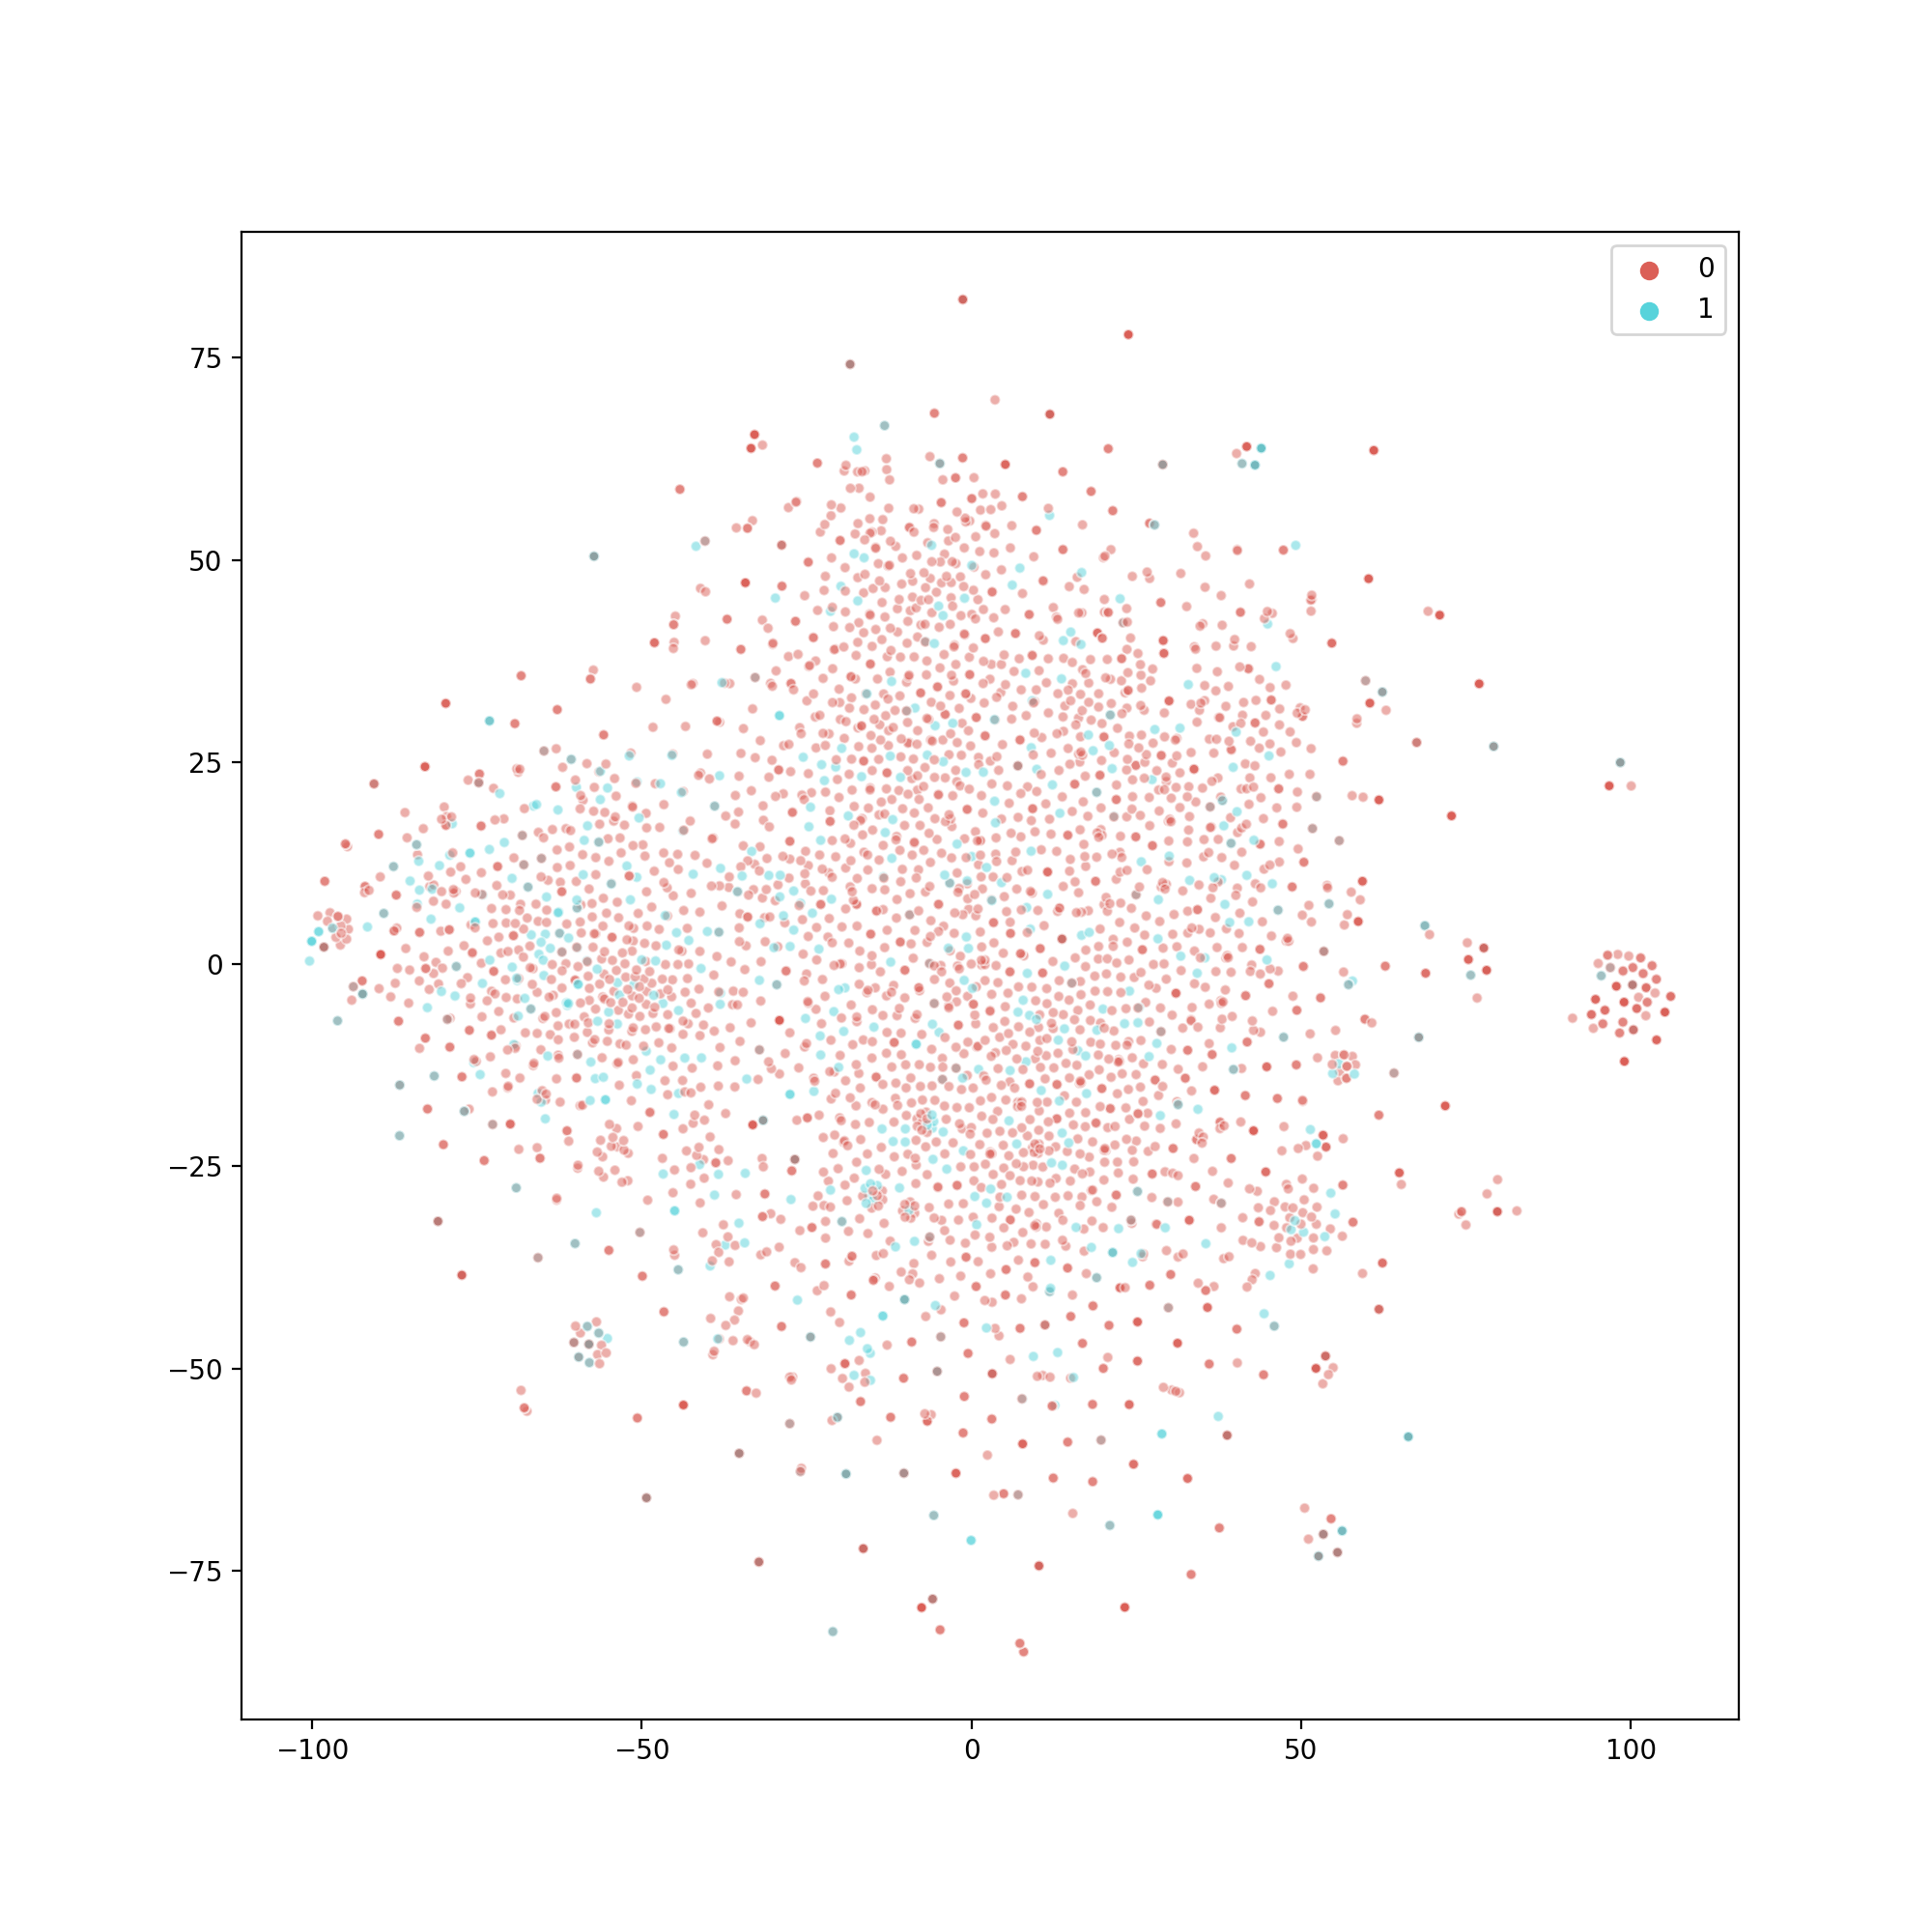

In [789]:
fig, ax = plt.subplots(figsize=(10, 10))

scp = sns.scatterplot(tsne_df[:,0], tsne_df[:,1], alpha=0.5, s=15, hue=colors, 
                      palette=sns.color_palette('hls', 2))

annot = ax.annotate("", xy=(0,0), xytext=(20,20), textcoords='offset points',
                    bbox=dict(boxstyle='round', fc='w'),
                    arrowprops=dict(arrowstyle='->'))
annot.set_visible(False)

def update_annot(ind):
    pos = scp.get_offsets()[ind['ind'][0]]
    annot.xy = pos
    text = '{}'.format(all_headlines[ind['ind'][0]])
    annot.set_text(text)
    annot.get_bbox_patch().set_facecolor('white')
    annot.get_bbox_patch().set_alpha(0.4)

def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = scp.contains(event)
        if cont: 
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()
                
fig.canvas.mpl_connect('motion_notify_event', hover)

plt.show()

Plot, colored by week

<IPython.core.display.Javascript object>


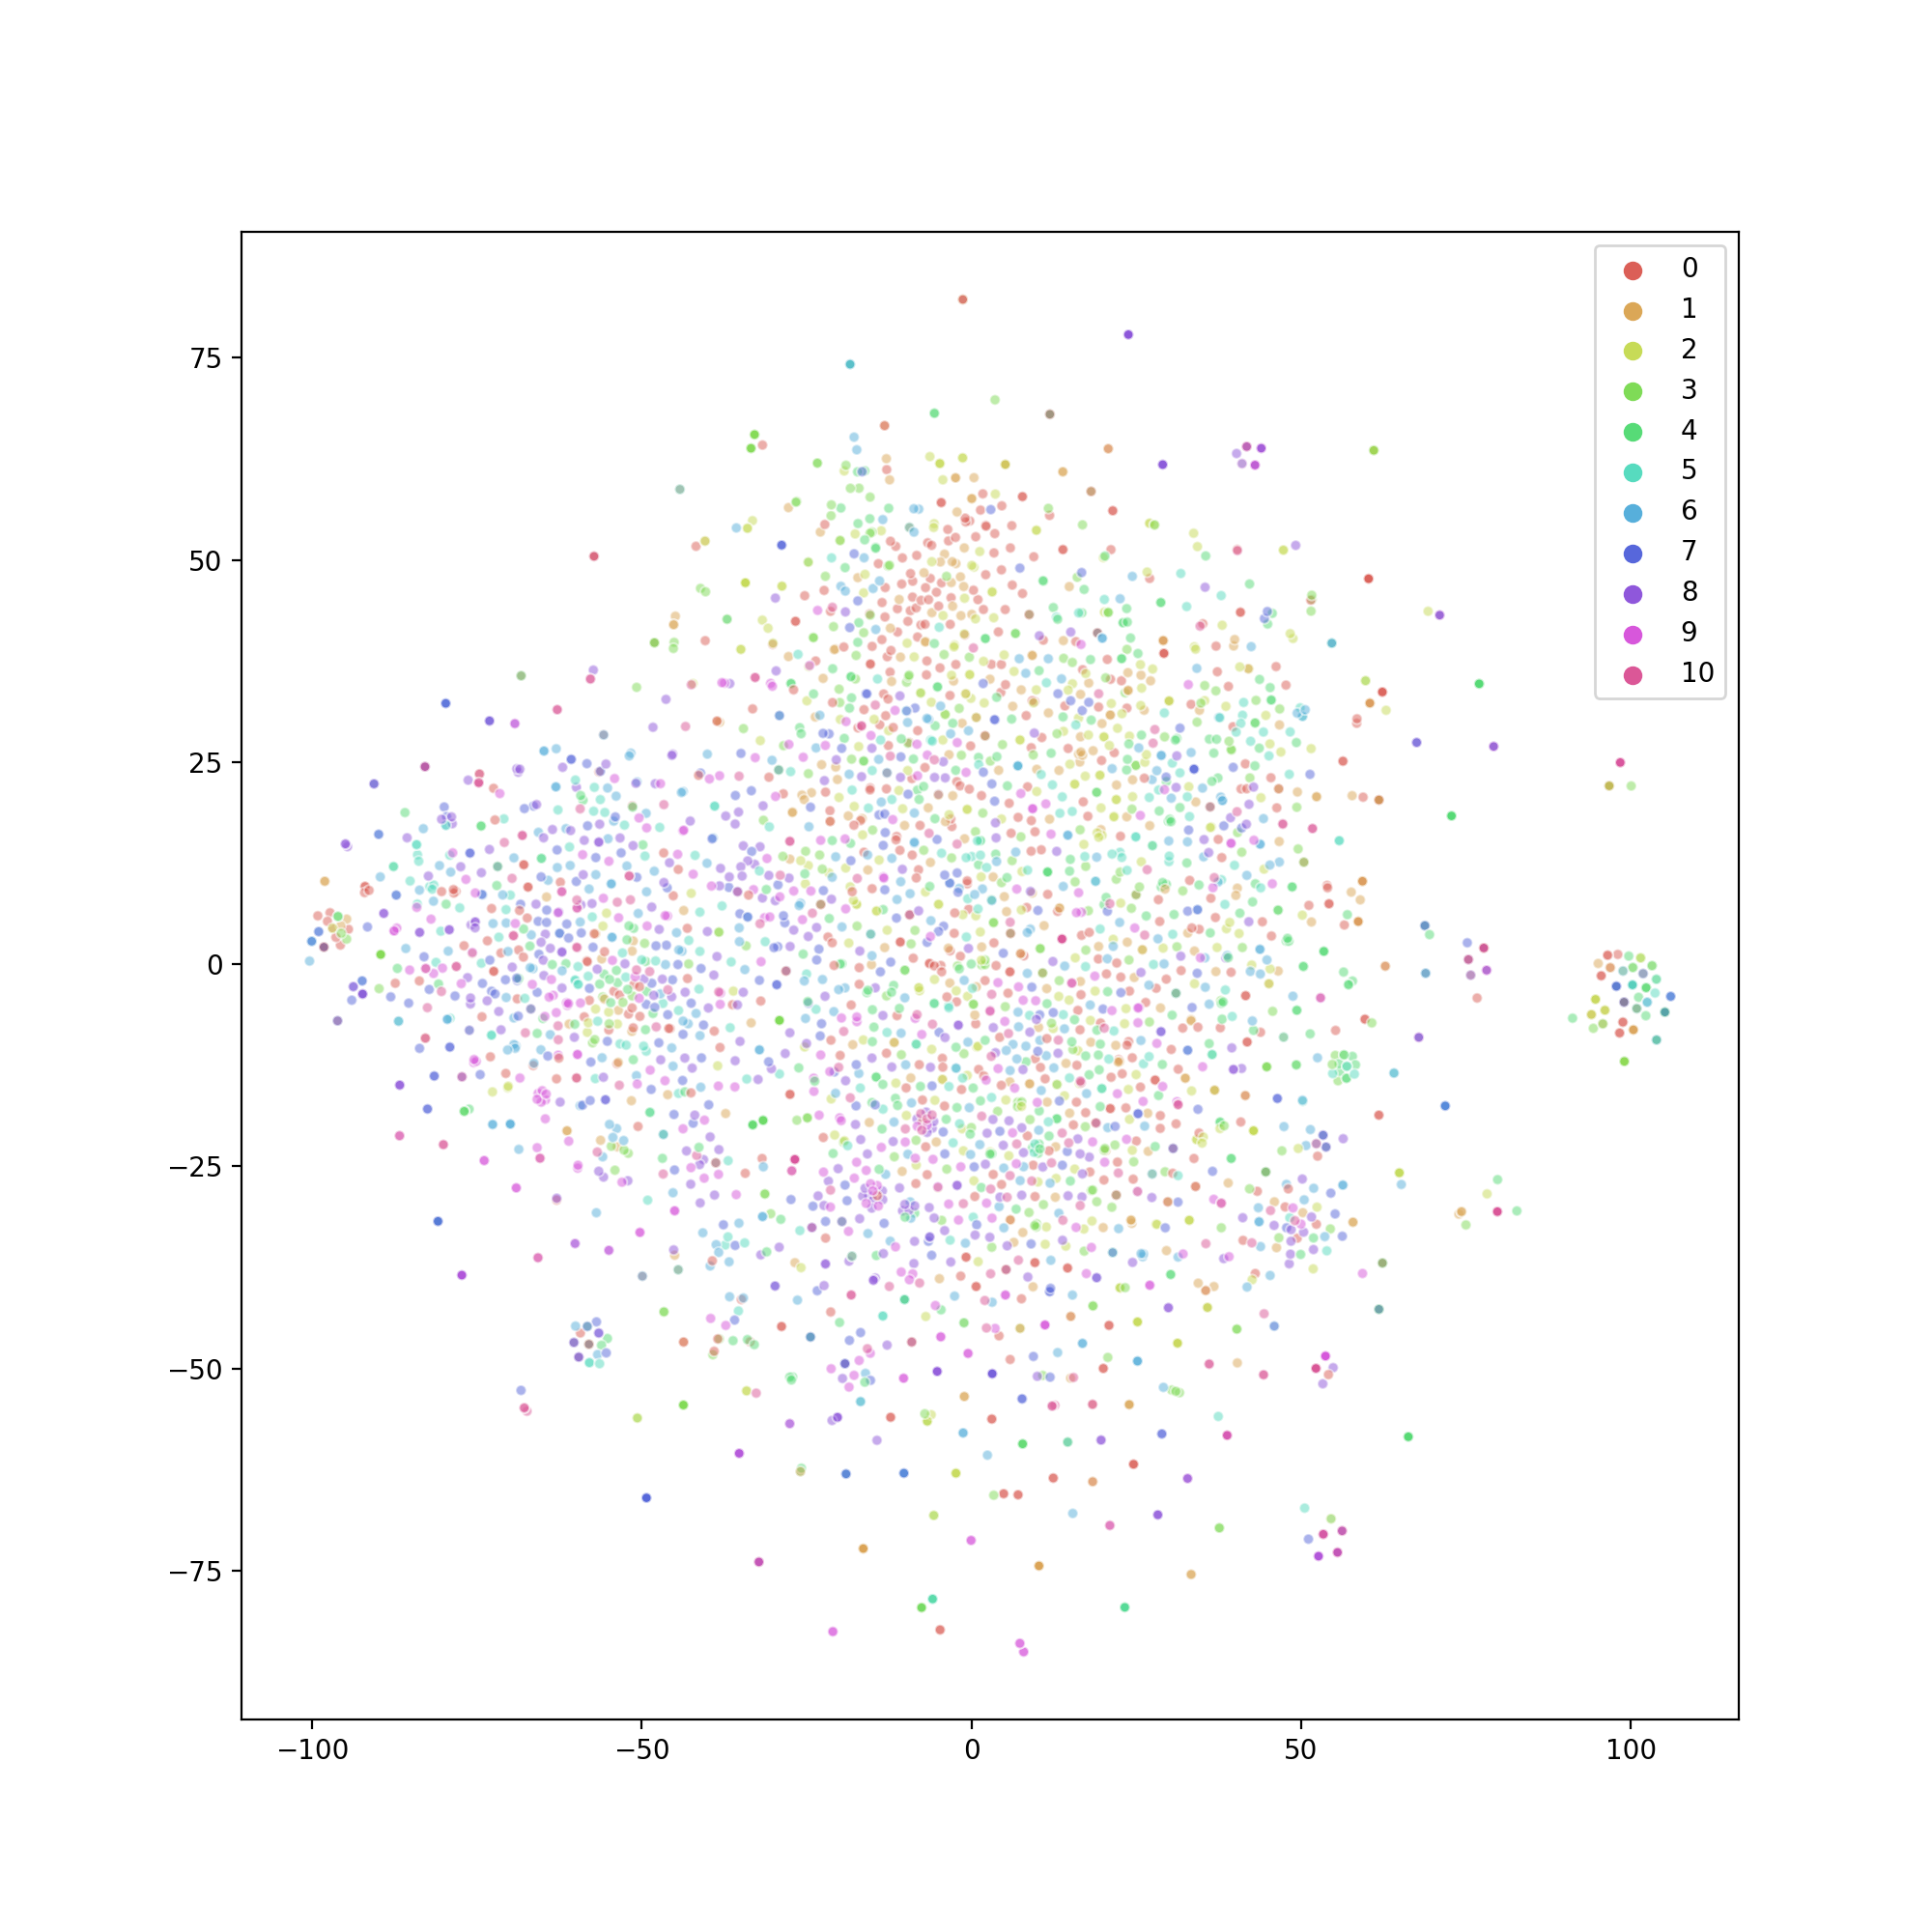

In [807]:
fig, ax = plt.subplots(figsize=(10, 10))

scp = sns.scatterplot(tsne_df[:,0], 
                      tsne_df[:,1], 
                      alpha=0.5, 
                      s=15, 
                      hue=colors_by_weeks,
                      palette=sns.color_palette('hls', 11))

annot = ax.annotate("", xy=(0,0), xytext=(20,20), textcoords='offset points',
                    bbox=dict(boxstyle='round', fc='w'),
                    arrowprops=dict(arrowstyle='->'))
annot.set_visible(False)

def update_annot(ind):
    pos = scp.get_offsets()[ind['ind'][0]]
    annot.xy = pos
    text = '{}'.format(all_headlines[ind['ind'][0]])
    annot.set_text(text)
    annot.get_bbox_patch().set_facecolor('white')
    annot.get_bbox_patch().set_alpha(0.4)

def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = scp.contains(event)
        if cont: 
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()
                
fig.canvas.mpl_connect('motion_notify_event', hover)

plt.show()

In [620]:
all_headlines[277]

'Alta and Snowbird are renowned ski destinations but crowded. Instead, try Solitude.'

In [622]:
all_headlines[325]

'It’s time for radical change at the Grammys — and the clock is ticking'

## Doc2vec

In [508]:
len(all_headlines)

4075

In [ ]:
words = ' '.join(all_headlines).split(' ')
words

In [ ]:
stop_words = set(stopwords.words('english'))
len(stop_words)

Tokenize each headline, removing stopwords. 

In [510]:
train_corpus = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i,_d in enumerate(all_headlines) if _d not in stop_words]

In [511]:
len(train_corpus)

4075

Train model.

In [542]:
model_doc2vec = Doc2Vec(vector_size=300,
                        alpha=0.025,
                        min_alpha = 0.001,
                        min_count=1,
                        workers=10, 
                        dm=1,
                        epochs=40)

model_doc2vec.build_vocab(train_corpus)

Train model for 10 epochs.

In [543]:
start = timer()
model_doc2vec.train(train_corpus, total_examples=model_doc2vec.corpus_count, epochs=model_doc2vec.epochs)
model_doc2vec.save('d2v.model')
print('Model Saved')
end = timer()
print ("Execution time HH:MM:SS:",timedelta(seconds=end-start))

Model Saved
Execution time HH:MM:SS: 0:00:23.755177


In [537]:
model_doc2vec[0]

array([ 1.3504637e-02,  8.2566766e-03, -2.1916255e-03,  4.3237326e-03,
       -9.4604604e-03,  1.5311696e-03, -1.2774942e-02, -6.5150219e-03,
       -1.2243640e-03, -1.4054816e-02, -1.3206872e-02, -6.5680663e-03,
        3.9786624e-04,  1.6083424e-03, -3.1921580e-03, -2.8327331e-03,
        2.4701109e-02, -6.5988651e-03,  2.4777565e-02,  1.7686073e-02,
        1.4777459e-02,  2.6327069e-04, -3.0054459e-02, -1.0576738e-02,
        1.0586901e-02,  1.7423746e-03, -5.0879340e-03, -5.7256166e-03,
        1.5045743e-02, -5.4006162e-03, -1.2176604e-02, -1.1682622e-02,
        9.5394859e-03, -1.9388972e-02, -3.3118133e-03, -6.8102687e-05,
        3.7937851e-03,  1.7227162e-02, -3.1893281e-03, -1.3738032e-03,
       -3.0077607e-04, -1.0218359e-02,  1.2085522e-02, -3.3307194e-03,
        1.2321858e-02, -4.2730637e-04,  5.6988602e-03, -3.3569229e-03,
       -1.1657155e-02,  9.3366858e-03,  3.0945492e-04,  2.5784165e-02,
       -1.6956830e-02,  2.9948445e-03, -1.1000807e-02, -6.3609325e-05,
      

Get the documents from the model.

In [515]:
doc_tags = list(model_doc2vec.docvecs.doctags.keys())
docs = model_doc2vec[doc_tags]
len(docs)

4075

In [516]:
docs[0]

array([ 0.07174653,  0.05016864,  0.03845977,  0.02634695, -0.07409763,
        0.02918518, -0.06415798, -0.05565873, -0.0027413 , -0.09055971],
      dtype=float32)

In [517]:
model_doc2vec.docvecs.most_similar(0)

[('3328', 0.9699888825416565),
 ('2767', 0.9683275818824768),
 ('504', 0.9664832353591919),
 ('2206', 0.9641293883323669),
 ('1856', 0.9629613161087036),
 ('2775', 0.9622619152069092),
 ('2449', 0.9612644910812378),
 ('1338', 0.96107417345047),
 ('602', 0.9608083367347717),
 ('267', 0.9546763300895691)]

In [518]:
all_headlines[0]

'House managers, Trump’s legal team spar over rules to guide trial'

In [519]:
all_headlines[3328]

'Chat Transcript: Ways to maintain your mental health during the coronavirus outbreak'

In [520]:
all_headlines[504]

'A guide to local favorites on Freret Street'

In [557]:
model_doc2vec.wv.most_similar('italy')

[('china', 0.9221874475479126),
 ('death', 0.9145364761352539),
 ('toll', 0.9133531451225281),
 ('deaths', 0.9032647609710693),
 (';', 0.9004700779914856),
 ('confirmed', 0.8946788907051086),
 ('cases', 0.8926124572753906),
 ('spike', 0.8825417757034302),
 ('spreads', 0.8822505474090576),
 ('plunge', 0.8802657723426819)]